<a href="https://colab.research.google.com/github/jackaleksa/sj-project/blob/main/Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout

In [3]:
data = np.array(pd.read_csv("data_set.csv"))
data.shape

(4962, 133)

In [4]:
unique_diseases = sorted(list(set(data[:,-1]))) #determines the number of unique diseases

#map the diseases to specific indices
diseases_indices = dict((c, i) for i, c in enumerate(unique_diseases))
indices_diseases = dict((i, c) for i, c in enumerate(unique_diseases))

print(diseases_indices)

X = np.zeros((len(data[:,:-1]), len(data[-1,:-1]), 41)) #num of cases x num of symptoms x num of diseases
Y = np.zeros((len(data[:,:-1]), 41))
print(X.shape)
print(Y.shape)

print(diseases_indices[data[20,-1]])

#one hot encoding for X and Y matrices
for i in range(len(data)):
  for j in range(len(data[0,:-1])):
    if data[i,j] == 1:
      X[i,j,diseases_indices[data[i,-1]]] = 1
  Y[i,diseases_indices[data[i,-1]]] = 1

indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]

#splits X and Y into test, train, and valid
train_ratio  = 0.8
train_length = X.shape[0]
train_split  = int(train_ratio*train_length)
X_test, Y_test = X[train_split:], Y[train_split:]
X_train, Y_train = X[:train_split], Y[:train_split] 

valid_ratio  = 0.75
valid_length = X_train.shape[0]
valid_split  = int(valid_ratio*valid_length)
X_valid, Y_valid = X_train[valid_split:], Y_train[valid_split:]
X_train, Y_train = X_train[:valid_split], Y_train[:valid_split]

{'(vertigo) Paroymsal  Positional Vertigo': 0, 'AIDS': 1, 'Acne': 2, 'Alcoholic hepatitis': 3, 'Allergy': 4, 'Arthritis': 5, 'Bronchial Asthma': 6, 'Cervical spondylosis': 7, 'Chicken pox': 8, 'Chronic cholestasis': 9, 'Common Cold': 10, 'Dengue': 11, 'Diabetes ': 12, 'Dimorphic hemmorhoids(piles)': 13, 'Drug Reaction': 14, 'Fungal infection': 15, 'GERD': 16, 'Gastroenteritis': 17, 'Heart attack': 18, 'Hepatitis B': 19, 'Hepatitis C': 20, 'Hepatitis D': 21, 'Hepatitis E': 22, 'Hypertension ': 23, 'Hyperthyroidism': 24, 'Hypoglycemia': 25, 'Hypothyroidism': 26, 'Impetigo': 27, 'Jaundice': 28, 'Malaria': 29, 'Migraine': 30, 'Osteoarthristis': 31, 'Paralysis (brain hemorrhage)': 32, 'Peptic ulcer diseae': 33, 'Pneumonia': 34, 'Psoriasis': 35, 'Tuberculosis': 36, 'Typhoid': 37, 'Urinary tract infection': 38, 'Varicose veins': 39, 'hepatitis A': 40}
(4962, 132, 41)
(4962, 41)
16


In [5]:
#running an LSTM model on the data
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[-2], X.shape[-1]))) # (batch, 128)
model.add(Dense(len(unique_diseases)))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               87040     
                                                                 
 dense (Dense)               (None, 41)                5289      
                                                                 
 activation (Activation)     (None, 41)                0         
                                                                 
Total params: 92,329
Trainable params: 92,329
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_valid, Y_valid))

Epoch 1/20
93/93 [==============================] - 24s 232ms/step - loss: 3.5995 - accuracy: 0.1159 - val_loss: 3.3752 - val_accuracy: 0.1098
Epoch 2/20
93/93 [==============================] - 17s 179ms/step - loss: 3.2655 - accuracy: 0.1169 - val_loss: 3.0929 - val_accuracy: 0.1098
Epoch 3/20
93/93 [==============================] - 17s 184ms/step - loss: 2.9138 - accuracy: 0.1566 - val_loss: 2.6476 - val_accuracy: 0.1913
Epoch 4/20
93/93 [==============================] - 19s 207ms/step - loss: 2.6971 - accuracy: 0.2241 - val_loss: 3.2048 - val_accuracy: 0.1480
Epoch 5/20
93/93 [==============================] - 16s 176ms/step - loss: 2.7422 - accuracy: 0.2322 - val_loss: 2.6560 - val_accuracy: 0.2548
Epoch 6/20
93/93 [==============================] - 18s 192ms/step - loss: 1.9008 - accuracy: 0.4083 - val_loss: 1.8646 - val_accuracy: 0.3807
Epoch 7/20
93/93 [==============================] - 19s 199ms/step - loss: 1.6567 - accuracy: 0.4671 - val_loss: 1.2845 - val_accuracy: 0.6183

In [7]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval)

32/32 [==============================] - 2s 58ms/step - loss: 0.1557 - accuracy: 0.9728
Test loss: [0.15565724670886993, 0.9728096723556519]


32/32 [==============================] - 2s 61ms/step


<Axes: >

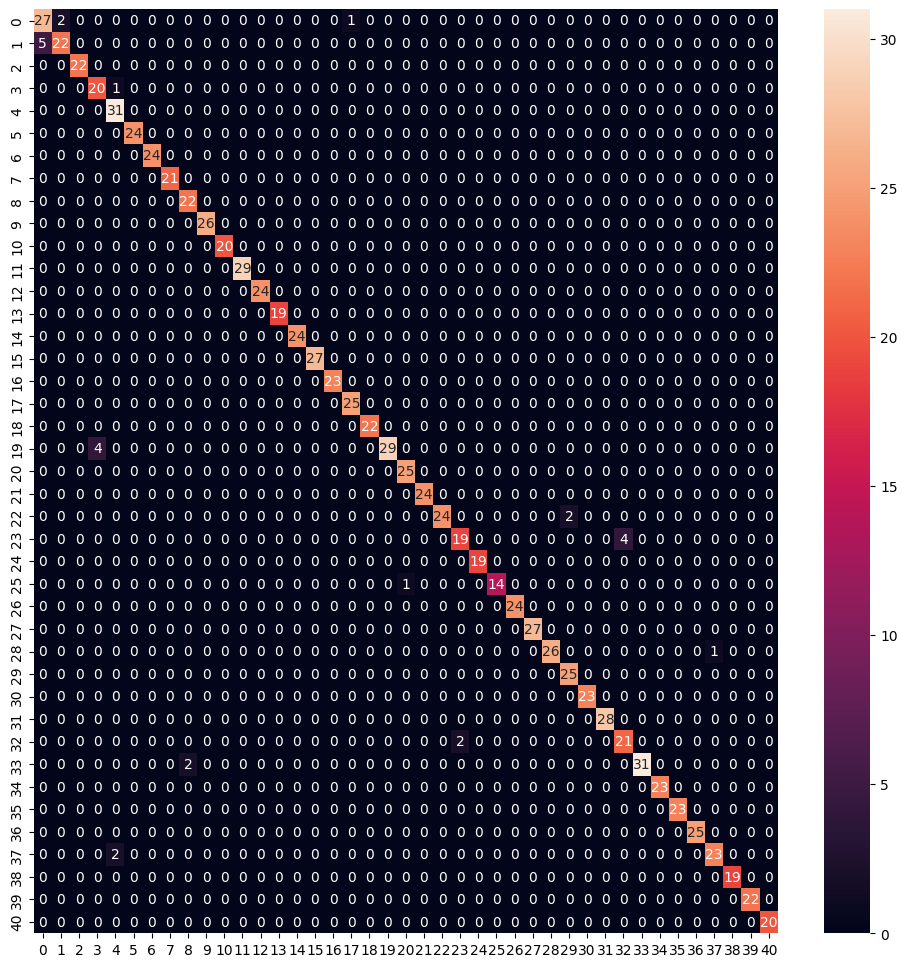

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#creating a heatmap for the model
y_pred=model.predict(X_test) 
cm = confusion_matrix(np.argmax(Y_test,1), np.argmax(y_pred,1))
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt="d")